In [1]:
#  pip install openpyxl

In [77]:
import matplotlib
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os


import seaborn as sns
from matplotlib import rcParams

#绘图前的基本设置

myfont = fm.FontProperties(fname=r'C:\Windows\Fonts\Times New Roman.tiff') # 设置字体

# 设置matplotlib正常显示中文和负号

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
# matplotlib.rcParams['font.sans-serif']=['NSimSun']   # 用黑体显示中文
# matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
matplotlib.rcParams['font.size'] = 18
# matplotlib.rcParams['font.family'] = 'sans-serif'  
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'  # NSimSun 新宋体字体   宋体：SimSuncss

%matplotlib inline  
#内嵌绘图，并且可以省略掉plt.show()这一步
os.chdir(r'E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5')


C:\Users\HP\AppData\Local\Temp\ipykernel_28896\3220736483.py:116: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


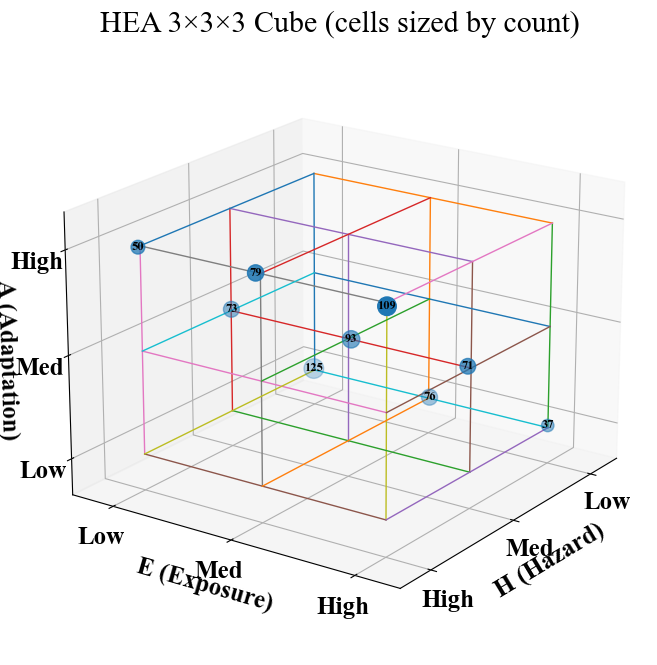

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

excel_path = Path("hazard_exposure_adaptation_index_results-hazard1-AGE.xlsx")
sheet_name = 0  # 或者写表名

# --------- 小工具：智能找列 + 处理重名列只取第一个 ----------
def detect_col(candidates, cols):
    lower_map = {str(c).lower(): c for c in cols}
    # 精确匹配
    for cand in candidates:
        if cand in cols:
            return cand
        if str(cand).lower() in lower_map:
            return lower_map[str(cand).lower()]
    # 模糊包含
    for c in cols:
        cl = str(c).lower()
        for cand in candidates:
            if str(cand).lower() in cl:
                return c
    return None

def get_series_unique(df_in: pd.DataFrame, col_name: str) -> pd.Series:
    """当列名重复时，只取第一个同名列，确保返回 Series"""
    idx = [i for i, c in enumerate(df_in.columns) if c == col_name]
    if not idx:
        raise KeyError(f"列不存在：{col_name}")
    return df_in.iloc[:, idx[0]]

def tri_binning(series: pd.Series):
    q33, q67 = series.quantile([0.3333, 0.6667])
    bins = [-np.inf, q33, q67, np.inf]
    labels = ["Low", "Med", "High"]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# --------- 读取并清洗 ----------
dfe = pd.read_excel(excel_path, sheet_name=sheet_name)
# 去掉列名前后空格，防止 " A " 这种情况
dfe.columns = [str(c).strip() for c in dfe.columns]

cols = list(dfe.columns)
H_col = detect_col(["H","Hazard","热浪危害","危害","热浪危险性","危险性"], cols) or "H"
E_col = detect_col(["E","Exposure","人口暴露","暴露","人口暴露度"], cols) or "E"
A_col = detect_col(["A","Adaptation","Adaptability","社会适应性","适应性"], cols) or "A"

# 关键修复：用 get_series_unique 取 **唯一 Series**
df_num = pd.DataFrame({
    "H": get_series_unique(dfe, H_col),
    "E": get_series_unique(dfe, E_col),
    "A": get_series_unique(dfe, A_col),
})

# 转数值
for c in ["H", "E", "A"]:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")
df_num = df_num.dropna().reset_index(drop=True)

# --------- 分档 ----------
df_num["H_bin"] = tri_binning(df_num["H"]).astype(str)
df_num["E_bin"] = tri_binning(df_num["E"]).astype(str)
df_num["A_bin"] = tri_binning(df_num["A"]).astype(str)

# --------- 3×3×3 计数与绘图 ----------
map3 = {"Low":0, "Med":1, "High":2}
df_num["Hx"] = df_num["H_bin"].map(map3)
df_num["Ey"] = df_num["E_bin"].map(map3)
df_num["Az"] = df_num["A_bin"].map(map3)

counts = df_num.groupby(["Hx","Ey","Az"]).size().reset_index(name="n")
if counts.empty:
    raise ValueError("分档为空，请检查 H/E/A 数据是否有效。")

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')

# 网格
ticks = [0,1,2]
for x in ticks:
    for y in ticks:
        ax.plot([x,x],[y,y],[0,2], linewidth=1)
for x in ticks:
    for z in ticks:
        ax.plot([x,x],[0,2],[z,z], linewidth=1)
for y in ticks:
    for z in ticks:
        ax.plot([0,2],[y,y],[z,z], linewidth=1)

# 散点（点大小 ∝ 样本数）
np.random.seed(0)
X = counts["Hx"].values + (np.random.rand(len(counts))-0.5)*0.05
Y = counts["Ey"].values + (np.random.rand(len(counts))-0.5)*0.05
Z = counts["Az"].values + (np.random.rand(len(counts))-0.5)*0.05
S = 30 + (counts["n"].values / counts["n"].max()) * 170
ax.scatter(X, Y, Z, s=S)

# 标注样本数
for xi, yi, zi, ni in zip(X, Y, Z, counts["n"].values):
    ax.text(xi, yi, zi, str(int(ni)), fontsize=9, ha='center', va='center')

ax.set_xlabel("H (Hazard)")
ax.set_ylabel("E (Exposure)")
ax.set_zlabel("A (Adaptation)")
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2]); ax.set_zticks([0,1,2])
ax.set_xticklabels(["Low","Med","High"])
ax.set_yticklabels(["Low","Med","High"])
ax.set_zticklabels(["Low","Med","High"])
ax.set_xlim(-0.3, 2.3); ax.set_ylim(-0.3, 2.3); ax.set_zlim(-0.3, 2.3)
ax.view_init(elev=20, azim=35)
ax.set_title("HEA 3×3×3 Cube (cells sized by count)")

plt.tight_layout()
plt.savefig(r'E:\BaiduSyncdisk\热浪博士论文\论文图片\PD-05-04-风险指数变化-无健康指数.png', dpi=400, bbox_inches='tight',facecolor="none", transparent=True)

plt.show()


已导出省份多年均值与立方体分档： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\province_mean_HEA_cube.csv
三分位阈值：
  Hazard Index:     q33=0.3891, q67=0.4271
  Exposure Index:    q33=0.2542, q67=0.4369
  Adaptation Index:  q33=0.1839, q67=0.2963
    地区    H_mean    E_mean    A_mean H_bin E_bin A_bin   Hx   Ey   Az  \
0   上海  0.297080  0.176498  0.263943   Low   Low   Med  0.0  0.0  1.0   
1   云南  0.336523  0.436850  0.224909   Low   Med   Med  0.0  1.0  1.0   
2  内蒙古  0.452430  0.211095  0.183854  High   Low   Low  2.0  0.0  0.0   
3   北京  0.480636  0.099909  0.305862  High   Low  High  2.0  0.0  2.0   
4   吉林  0.389131  0.254259  0.183897   Med   Med   Med  1.0  1.0  1.0   

  cube_cell cube_label  
0  H0-E0-A1        LLM  
1  H0-E1-A1        LMM  
2  H2-E0-A0        HLL  
3  H2-E0-A2        HLH  
4  H1-E1-A1        MMM  


C:\Users\HP\AppData\Local\Temp\ipykernel_28896\2970600131.py:127: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_28896\2970600131.py:128: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  plt.savefig(out_fig, dpi=400, bbox_inches='tight', facecolor="none", transparent=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_28896\2970600131.py:128: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  plt.savefig(out_fig, dpi=400, bbox_inches='tight', facecolor="none", transparent=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_28896\2970600131.py:128: UserWarning: Glyph 20113 (\N{CJK UNIFIED IDEOGRAPH-4E91}) missing from current font.
  plt.savefig(out_fig, dpi=400, bbox_inches='tight', facecolor="none", transparent=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_28896\2970600131.py:1

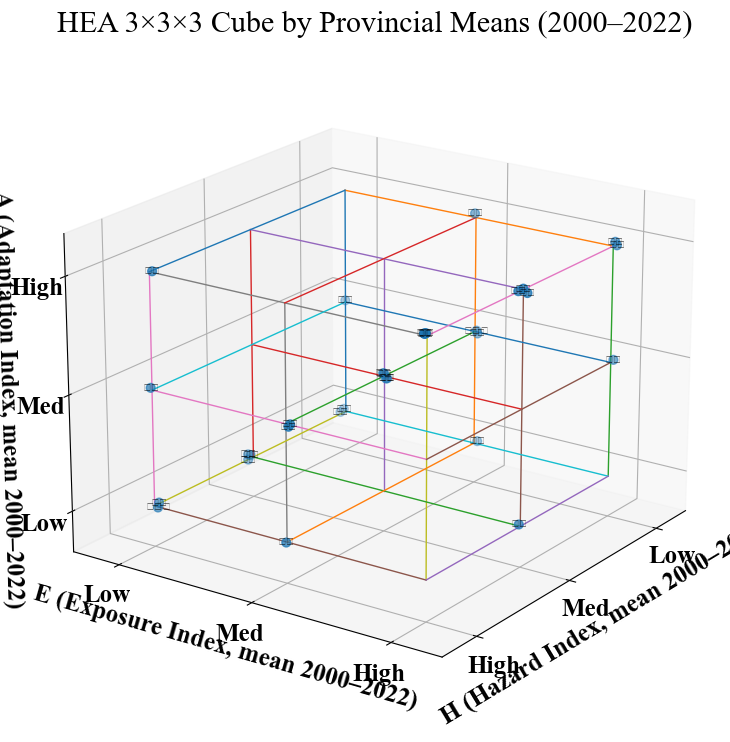

已保存立方体分布图： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\HEA_cube_by_province_means.png


In [17]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ===================== 0) 参数区（按需修改） =====================
excel_path = Path("hazard_exposure_adaptation_index_results-hazard1-AGE.xlsx")
sheet_name = 0                 # 或改为工作表名 "Sheet1"
PROVINCE_COL = "地区"          # 若你的列名是 "地区" 或 "Province" 请改这里
YEAR_COL     = "年份"          # 若没有年份列，设为 None
H_col = "Hazard Index"
E_col = "Exposure Index"
A_col = "Adaptation Index"

YEAR_MIN, YEAR_MAX = 2000, 2022  # 研究期（若无年份列将被忽略）

out_csv = Path("province_mean_HEA_cube.csv")
out_fig = Path("HEA_cube_by_province_means.png")

# ===================== 1) 读取与清洗 =====================
if not excel_path.exists():
    raise FileNotFoundError(f"未找到数据文件：{excel_path.resolve()}")

df = pd.read_excel(excel_path, sheet_name=sheet_name)
df.columns = [str(c).strip() for c in df.columns]

# 必要列检查
need_cols = [PROVINCE_COL, H_col, E_col, A_col]
if YEAR_COL and YEAR_COL in df.columns:
    need_cols.append(YEAR_COL)

missing = [c for c in [PROVINCE_COL, H_col, E_col, A_col] if c not in df.columns]
if missing:
    raise ValueError(f"缺少必要列：{missing}\n现有列：{list(df.columns)}")

df = df[need_cols].copy()

# 数值化 & 去缺失
for c in [H_col, E_col, A_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[H_col, E_col, A_col]).reset_index(drop=True)

# 年份限定（若存在年份列）
if YEAR_COL and YEAR_COL in df.columns:
    df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce")
    df = df[(df[YEAR_COL] >= YEAR_MIN) & (df[YEAR_COL] <= YEAR_MAX)]

# ===================== 2) 计算省份多年均值 =====================
df_mean = df.groupby(PROVINCE_COL)[[H_col, E_col, A_col]].mean().reset_index()
df_mean.rename(columns={H_col: "H_mean", E_col: "E_mean", A_col: "A_mean"}, inplace=True)

# ===================== 3) 三分位分档（Low/Med/High） =====================
def tri_binning(series: pd.Series):
    """按 33%/67% 分位切分，并返回分档与阈值"""
    q33, q67 = series.quantile([0.3333, 0.6667])
    bins = [-np.inf, q33, q67, np.inf]
    labels = ["Low", "Med", "High"]
    binned = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return binned, (float(q33), float(q67))

df_mean["H_bin"], H_thr = tri_binning(df_mean["H_mean"])
df_mean["E_bin"], E_thr = tri_binning(df_mean["E_mean"])
df_mean["A_bin"], A_thr = tri_binning(df_mean["A_mean"])

# 将分档映射为数值坐标（Low=0, Med=1, High=2），并强制为 float，避免 dtype 报错
map3 = {"Low": 0, "Med": 1, "High": 2}
df_mean["Hx"] = df_mean["H_bin"].map(map3).astype(float)
df_mean["Ey"] = df_mean["E_bin"].map(map3).astype(float)
df_mean["Az"] = df_mean["A_bin"].map(map3).astype(float)

# 立方体格子编码（可用于表格检索）
df_mean["cube_cell"]  = "H" + df_mean["Hx"].astype(int).astype(str) + \
                        "-E" + df_mean["Ey"].astype(int).astype(str) + \
                        "-A" + df_mean["Az"].astype(int).astype(str)
df_mean["cube_label"] = df_mean["H_bin"].str[0] + df_mean["E_bin"].str[0] + df_mean["A_bin"].str[0]

# ===================== 4) 导出表格与阈值摘要 =====================
df_mean.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("已导出省份多年均值与立方体分档：", out_csv.resolve())
print("三分位阈值：")
print(f"  Hazard Index:     q33={H_thr[0]:.4f}, q67={H_thr[1]:.4f}")
print(f"  Exposure Index:    q33={E_thr[0]:.4f}, q67={E_thr[1]:.4f}")
print(f"  Adaptation Index:  q33={A_thr[0]:.4f}, q67={A_thr[1]:.4f}")
print(df_mean.head())

# ===================== 5) 3×3×3 立方体散点图（每点=一个省份） =====================
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

# 画立方体网格
ticks = [0, 1, 2]
for x in ticks:
    for y in ticks:
        ax.plot([x, x], [y, y], [0, 2], linewidth=1)
for x in ticks:
    for z in ticks:
        ax.plot([x, x], [0, 2], [z, z], linewidth=1)
for y in ticks:
    for z in ticks:
        ax.plot([0, 2], [y, y], [z, z], linewidth=1)

# 点位：在格子中心加少量随机抖动，避免多个省份重叠
np.random.seed(1)
X = df_mean["Hx"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06
Y = df_mean["Ey"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06
Z = df_mean["Az"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06

ax.scatter(X, Y, Z, s=40)

# 打上省份标签（如太密可注释）
for xi, yi, zi, name in zip(X, Y, Z, df_mean[PROVINCE_COL].values):
    ax.text(xi, yi, zi, str(name), fontsize=8, ha='center', va='center')

ax.set_xlabel("H (Hazard Index, mean 2000–2022)")
ax.set_ylabel("E (Exposure Index, mean 2000–2022)")
ax.set_zlabel("A (Adaptation Index, mean 2000–2022)")
ax.set_xticks([0, 1, 2]); ax.set_yticks([0, 1, 2]); ax.set_zticks([0, 1, 2])
ax.set_xticklabels(["Low", "Med", "High"])
ax.set_yticklabels(["Low", "Med", "High"])
ax.set_zticklabels(["Low", "Med", "High"])
ax.set_xlim(-0.3, 2.3); ax.set_ylim(-0.3, 2.3); ax.set_zlim(-0.3, 2.3)
ax.view_init(elev=20, azim=35)
ax.set_title("HEA 3×3×3 Cube by Provincial Means (2000–2022)")

plt.tight_layout()
plt.savefig(out_fig, dpi=400, bbox_inches='tight', facecolor="none", transparent=True)
plt.show()
print("已保存立方体分布图：", out_fig.resolve())


已导出省份多年均值与立方体分档： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\province_mean_HEA_cube.csv
三分位阈值：
  Hazard Index:     q33=0.3891, q67=0.4271
  Exposure Index:    q33=0.2542, q67=0.4369
  Adaptation Index:  q33=0.1839, q67=0.2963
    地区    H_mean    E_mean    A_mean H_bin E_bin A_bin   Hx   Ey   Az  \
0   上海  0.297080  0.176498  0.263943   Low   Low   Med  0.0  0.0  1.0   
1   云南  0.336523  0.436850  0.224909   Low   Med   Med  0.0  1.0  1.0   
2  内蒙古  0.452430  0.211095  0.183854  High   Low   Low  2.0  0.0  0.0   
3   北京  0.480636  0.099909  0.305862  High   Low  High  2.0  0.0  2.0   
4   吉林  0.389131  0.254259  0.183897   Med   Med   Med  1.0  1.0  1.0   

  cube_cell cube_label  
0  H0-E0-A1        LLM  
1  H0-E1-A1        LMM  
2  H2-E0-A0        HLL  
3  H2-E0-A2        HLH  
4  H1-E1-A1        MMM  


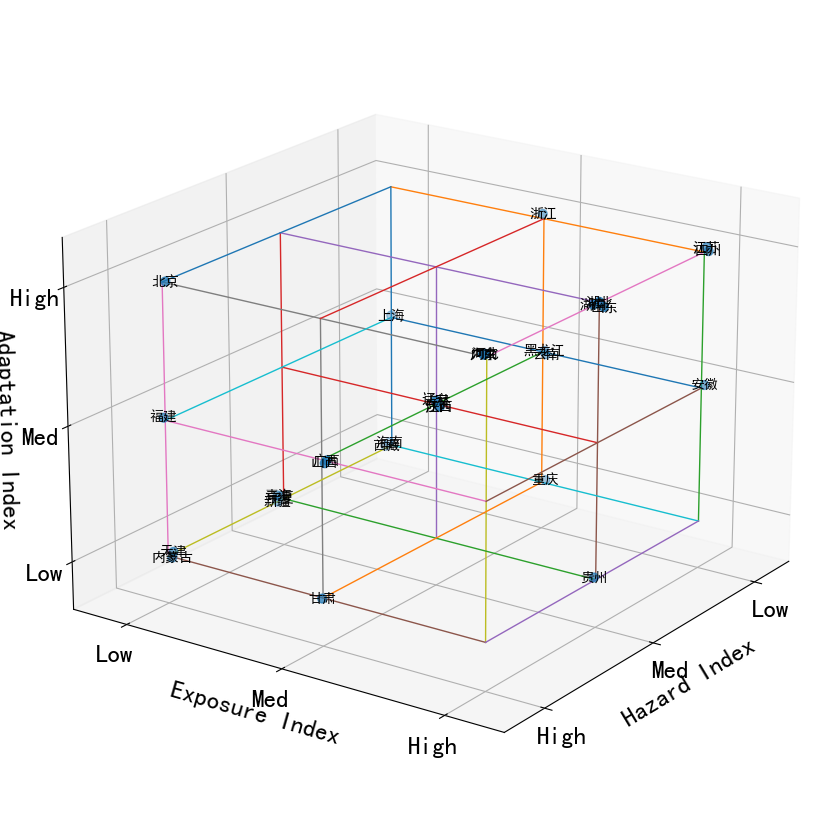

已保存立方体分布图： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\HEA_cube_by_province_means.png


In [69]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定黑体，解决中文显示问题
matplotlib.rcParams['axes.unicode_minus'] = False
# ===================== 0) 参数区（按需修改） =====================
excel_path = Path("hazard_exposure_adaptation_index_results-hazard1-AGE.xlsx")
sheet_name = 0                 # 或改为工作表名 "Sheet1"
PROVINCE_COL = "地区"          # 若你的列名是 "地区" 或 "Province" 请改这里
YEAR_COL     = "年份"          # 若没有年份列，设为 None
H_col = "Hazard Index"
E_col = "Exposure Index"
A_col = "Adaptation Index"

YEAR_MIN, YEAR_MAX = 2000, 2022  # 研究期（若无年份列将被忽略）

out_csv = Path("province_mean_HEA_cube.csv")
out_fig = Path("HEA_cube_by_province_means.png")

# ===================== 1) 读取与清洗 =====================
if not excel_path.exists():
    raise FileNotFoundError(f"未找到数据文件：{excel_path.resolve()}")

df = pd.read_excel(excel_path, sheet_name=sheet_name)
df.columns = [str(c).strip() for c in df.columns]

# 必要列检查
need_cols = [PROVINCE_COL, H_col, E_col, A_col]
if YEAR_COL and YEAR_COL in df.columns:
    need_cols.append(YEAR_COL)

missing = [c for c in [PROVINCE_COL, H_col, E_col, A_col] if c not in df.columns]
if missing:
    raise ValueError(f"缺少必要列：{missing}\n现有列：{list(df.columns)}")

df = df[need_cols].copy()

# 数值化 & 去缺失
for c in [H_col, E_col, A_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[H_col, E_col, A_col]).reset_index(drop=True)

# 年份限定（若存在年份列）
if YEAR_COL and YEAR_COL in df.columns:
    df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce")
    df = df[(df[YEAR_COL] >= YEAR_MIN) & (df[YEAR_COL] <= YEAR_MAX)]

# ===================== 2) 计算省份多年均值 =====================
df_mean = df.groupby(PROVINCE_COL)[[H_col, E_col, A_col]].mean().reset_index()
df_mean.rename(columns={H_col: "H_mean", E_col: "E_mean", A_col: "A_mean"}, inplace=True)

# ===================== 3) 三分位分档（Low/Med/High） =====================
def tri_binning(series: pd.Series):
    """按 33%/67% 分位切分，并返回分档与阈值"""
    q33, q67 = series.quantile([0.3333, 0.6667])
    bins = [-np.inf, q33, q67, np.inf]
    labels = ["Low", "Med", "High"]
    binned = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return binned, (float(q33), float(q67))

df_mean["H_bin"], H_thr = tri_binning(df_mean["H_mean"])
df_mean["E_bin"], E_thr = tri_binning(df_mean["E_mean"])
df_mean["A_bin"], A_thr = tri_binning(df_mean["A_mean"])

# 将分档映射为数值坐标（Low=0, Med=1, High=2），并强制为 float，避免 dtype 报错
map3 = {"Low": 0, "Med": 1, "High": 2}
df_mean["Hx"] = df_mean["H_bin"].map(map3).astype(float)
df_mean["Ey"] = df_mean["E_bin"].map(map3).astype(float)
df_mean["Az"] = df_mean["A_bin"].map(map3).astype(float)

# 立方体格子编码（可用于表格检索）
df_mean["cube_cell"]  = "H" + df_mean["Hx"].astype(int).astype(str) + \
                        "-E" + df_mean["Ey"].astype(int).astype(str) + \
                        "-A" + df_mean["Az"].astype(int).astype(str)
df_mean["cube_label"] = df_mean["H_bin"].str[0] + df_mean["E_bin"].str[0] + df_mean["A_bin"].str[0]

# ===================== 4) 导出表格与阈值摘要 =====================
df_mean.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("已导出省份多年均值与立方体分档：", out_csv.resolve())
print("三分位阈值：")
print(f"  Hazard Index:     q33={H_thr[0]:.4f}, q67={H_thr[1]:.4f}")
print(f"  Exposure Index:    q33={E_thr[0]:.4f}, q67={E_thr[1]:.4f}")
print(f"  Adaptation Index:  q33={A_thr[0]:.4f}, q67={A_thr[1]:.4f}")
print(df_mean.head())

# ===================== 5) 3×3×3 立方体散点图（每点=一个省份） =====================
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

# 画立方体网格
ticks = [0, 1, 2]
for x in ticks:
    for y in ticks:
        ax.plot([x, x], [y, y], [0, 2], linewidth=1)
for x in ticks:
    for z in ticks:
        ax.plot([x, x], [0, 2], [z, z], linewidth=1)
for y in ticks:
    for z in ticks:
        ax.plot([0, 2], [y, y], [z, z], linewidth=1)

# 点位：在格子中心加少量随机抖动，避免多个省份重叠
np.random.seed(1)
X = df_mean["Hx"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06
Y = df_mean["Ey"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06
Z = df_mean["Az"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06

ax.scatter(X, Y, Z, s=40)

# 打上省份标签（如太密可注释）
for xi, yi, zi, name in zip(X, Y, Z, df_mean[PROVINCE_COL].values):
    ax.text(xi, yi, zi, str(name), fontsize=10, ha='center', va='center')

ax.set_xlabel("Hazard Index")
ax.set_ylabel("Exposure Index")
ax.set_zlabel("Adaptation Index")
ax.set_xticks([0, 1, 2]); ax.set_yticks([0, 1, 2]); ax.set_zticks([0, 1, 2])
ax.set_xticklabels(["Low", "Med", "High"])
ax.set_yticklabels(["Low", "Med", "High"])
ax.set_zticklabels(["Low", "Med", "High"])
ax.set_xlim(-0.3, 2.3); ax.set_ylim(-0.3, 2.3); ax.set_zlim(-0.3, 2.3)
ax.view_init(elev=20, azim=35)
# ax.set_title("HEA 3×3×3 Cube by Provincial Means (2000–2022)")

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.savefig(out_fig, dpi=400, bbox_inches='tight', facecolor="none", transparent=True)

# plt.tight_layout()
# plt.savefig(out_fig, dpi=400, bbox_inches='tight', facecolor="none", transparent=True)
plt.show()
print("已保存立方体分布图：", out_fig.resolve())


已导出省份多年均值与立方体分档： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\province_mean_HEA_cube.csv
三分位阈值：
  Hazard Index:     q33=0.3891, q67=0.4271
  Exposure Index:    q33=0.2542, q67=0.4369
  Adaptation Index:  q33=0.1839, q67=0.2963
    地区    H_mean    E_mean    A_mean H_bin E_bin A_bin   Hx   Ey   Az  \
0   上海  0.297080  0.176498  0.263943   Low   Low   Med  0.0  0.0  1.0   
1   云南  0.336523  0.436850  0.224909   Low   Med   Med  0.0  1.0  1.0   
2  内蒙古  0.452430  0.211095  0.183854  High   Low   Low  2.0  0.0  0.0   
3   北京  0.480636  0.099909  0.305862  High   Low  High  2.0  0.0  2.0   
4   吉林  0.389131  0.254259  0.183897   Med   Med   Med  1.0  1.0  1.0   

  cube_cell cube_label  
0  H0-E0-A1        LLM  
1  H0-E1-A1        LMM  
2  H2-E0-A0        HLL  
3  H2-E0-A2        HLH  
4  H1-E1-A1        MMM  


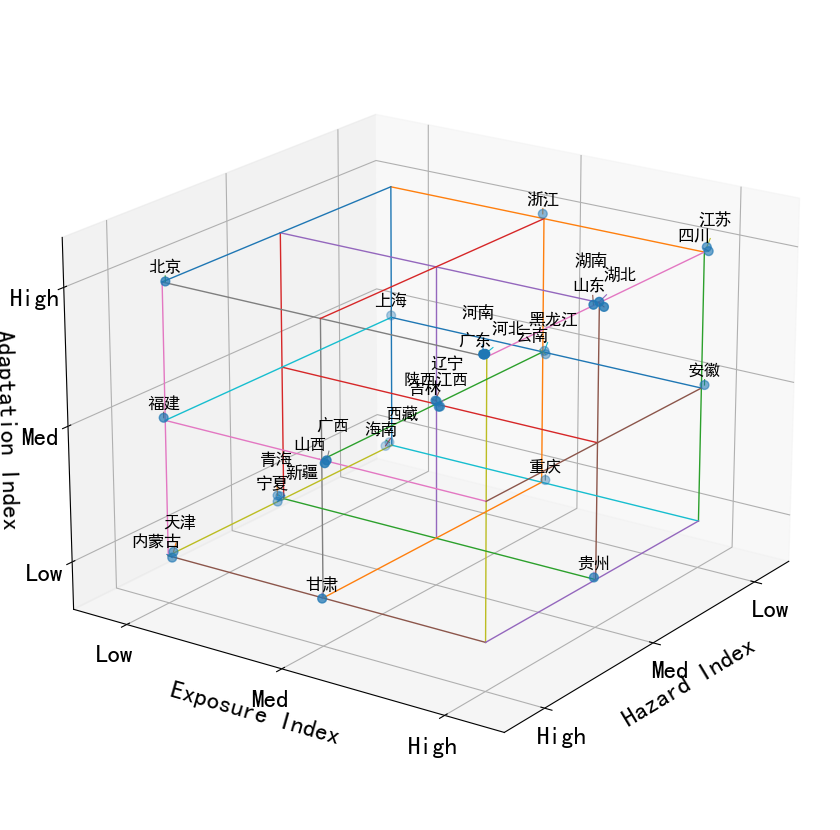

已保存立方体分布图： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\HEA_cube_by_province_means.png


In [87]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib

# ===================== 0) 基本设置（按需修改） =====================
# 中文字体 & 负号正常显示
# matplotlib.rcParams['font.sans-serif'] = ['SimHei']      # 或 ['Microsoft YaHei']
# matplotlib.rcParams['axes.unicode_minus'] = False

excel_path = Path("hazard_exposure_adaptation_index_results-hazard1-AGE.xlsx")
sheet_name = 0                 # 或改为工作表名 "Sheet1"
PROVINCE_COL = "地区"          # 若你的列名是 "省份" / "Province"，请改这里
YEAR_COL     = "年份"          # 若没有年份列，设为 None
H_col = "Hazard Index"
E_col = "Exposure Index"
A_col = "Adaptation Index"

YEAR_MIN, YEAR_MAX = 2000, 2022  # 研究期（若无年份列将被忽略）

out_csv = Path("province_mean_HEA_cube.csv")
out_fig = Path("HEA_cube_by_province_means.png")

# ===================== 1) 读取与清洗 =====================
if not excel_path.exists():
    raise FileNotFoundError(f"未找到数据文件：{excel_path.resolve()}")

df = pd.read_excel(excel_path, sheet_name=sheet_name)
df.columns = [str(c).strip() for c in df.columns]

# 必要列检查
need_cols = [PROVINCE_COL, H_col, E_col, A_col]
if YEAR_COL and YEAR_COL in df.columns:
    need_cols.append(YEAR_COL)

missing = [c for c in [PROVINCE_COL, H_col, E_col, A_col] if c not in df.columns]
if missing:
    raise ValueError(f"缺少必要列：{missing}\n现有列：{list(df.columns)}")

df = df[need_cols].copy()

# 数值化 & 去缺失
for c in [H_col, E_col, A_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[H_col, E_col, A_col]).reset_index(drop=True)

# 年份限定（若存在年份列）
if YEAR_COL and YEAR_COL in df.columns:
    df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce")
    df = df[(df[YEAR_COL] >= YEAR_MIN) & (df[YEAR_COL] <= YEAR_MAX)]

# ===================== 2) 计算省份多年均值 =====================
df_mean = df.groupby(PROVINCE_COL)[[H_col, E_col, A_col]].mean().reset_index()
df_mean.rename(columns={H_col: "H_mean", E_col: "E_mean", A_col: "A_mean"}, inplace=True)

# ===================== 3) 三分位分档（Low/Med/High） =====================
def tri_binning(series: pd.Series):
    """按 33%/67% 分位切分，并返回分档与阈值"""
    q33, q67 = series.quantile([0.3333, 0.6667])
    bins = [-np.inf, q33, q67, np.inf]
    labels = ["Low", "Med", "High"]
    binned = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return binned, (float(q33), float(q67))

df_mean["H_bin"], H_thr = tri_binning(df_mean["H_mean"])
df_mean["E_bin"], E_thr = tri_binning(df_mean["E_mean"])
df_mean["A_bin"], A_thr = tri_binning(df_mean["A_mean"])

# 将分档映射为数值坐标（Low=0, Med=1, High=2），并强制为 float，避免 dtype 报错
map3 = {"Low": 0, "Med": 1, "High": 2}
df_mean["Hx"] = df_mean["H_bin"].map(map3).astype(float)
df_mean["Ey"] = df_mean["E_bin"].map(map3).astype(float)
df_mean["Az"] = df_mean["A_bin"].map(map3).astype(float)

# 立方体格子编码（可用于表格检索）
df_mean["cube_cell"]  = "H" + df_mean["Hx"].astype(int).astype(str) + \
                        "-E" + df_mean["Ey"].astype(int).astype(str) + \
                        "-A" + df_mean["Az"].astype(int).astype(str)
df_mean["cube_label"] = df_mean["H_bin"].str[0] + df_mean["E_bin"].str[0] + df_mean["A_bin"].str[0]

# ===================== 4) 导出表格与阈值摘要 =====================
df_mean.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("已导出省份多年均值与立方体分档：", out_csv.resolve())
print("三分位阈值：")
print(f"  Hazard Index:     q33={H_thr[0]:.4f}, q67={H_thr[1]:.4f}")
print(f"  Exposure Index:    q33={E_thr[0]:.4f}, q67={E_thr[1]:.4f}")
print(f"  Adaptation Index:  q33={A_thr[0]:.4f}, q67={A_thr[1]:.4f}")
print(df_mean.head())

# ===================== 5) 3×3×3 立方体散点图（每点=一个省份） =====================
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

# 画立方体网格
ticks = [0, 1, 2]
for x in ticks:
    for y in ticks:
        ax.plot([x, x], [y, y], [0, 2], linewidth=1)
for x in ticks:
    for z in ticks:
        ax.plot([x, x], [0, 2], [z, z], linewidth=1)
for y in ticks:
    for z in ticks:
        ax.plot([0, 2], [y, y], [z, z], linewidth=1)

# 点位：在格子中心加少量随机抖动，避免多个省份重叠
np.random.seed(1)
X = df_mean["Hx"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06
Y = df_mean["Ey"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06
Z = df_mean["Az"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06

ax.scatter(X, Y, Z, s=40)

# ---------------- 标签防重叠：按格子分组分散 + 轻微抬升，并加短领结线 ----------------
# 基于整数格子中心（Hx,Ey,Az），对同格子的多个标签做圆形分布+Z方向错层
center_keys = list(zip(df_mean["Hx"].astype(int), df_mean["Ey"].astype(int), df_mean["Az"].astype(int)))
groups = {}
for idx, key in enumerate(center_keys):
    groups.setdefault(key, []).append(idx)

# 参数可按需要微调
r_base = 0.10     # 水平偏移半径（单位=格子坐标）
r_step = 0.02     # 多标签时逐步增大半径
z_step = 0.05     # 垂直方向错层步长
text_fs = 12       # 标签字号
line_len = 0.06   # 领结线长度

# 计算标签位置（与散点位置独立），再画领结线连回散点
for key, idx_list in groups.items():
    n = len(idx_list)
    if n == 1:
        # 只有一个标签：用原散点位置，稍微上抬一点
        i = idx_list[0]
        xi, yi, zi = X[i], Y[i], Z[i]
        xt, yt, zt = xi, yi, zi + z_step  # 轻微上抬
        # 领结线
        ax.plot([xi, xt], [yi, yt], [zi, zt - 0.01], linewidth=0.8)
        ax.text(xt, yt, zt, str(df_mean.loc[i, PROVINCE_COL]), fontsize=text_fs, ha='center', va='bottom')
    else:
        # 多个标签：均匀分布在圆上，并逐步增大半径、错层Z
        angles = np.linspace(0, 2*np.pi, n, endpoint=False)
        for rank, (i, ang) in enumerate(zip(idx_list, angles)):
            # 以整数格子中心为参照，构造标签位置（而不是直接用散点随机扰动）
            cx, cy, cz = key[0], key[1], key[2]
            r = r_base + r_step * (rank // 6)  # 标签多时逐圈扩散
            xt = cx + r * np.cos(ang)
            yt = cy + r * np.sin(ang)
            zt = cz + 0.10 + (rank % 3) * z_step  # 稍微抬高并错层

            # 领结线：从散点处拉一小段线到标签
            xi, yi, zi = X[i], Y[i], Z[i]
            # 控制线段长度：向标签方向画 line_len 的小段
            vx, vy, vz = xt - xi, yt - yi, zt - zi
            norm = max(np.sqrt(vx*vx + vy*vy + vz*vz), 1e-6)
            px = xi + vx / norm * line_len
            py = yi + vy / norm * line_len
            pz = zi + vz / norm * line_len
            ax.plot([xi, px], [yi, py], [zi, pz], linewidth=0.8)

            ax.text(xt, yt, zt, str(df_mean.loc[i, PROVINCE_COL]), fontsize=text_fs, fontweight= "bold",ha='center', va='bottom')

# 轴设置
ax.set_xlabel("Hazard Index")
ax.set_ylabel("Exposure Index")
ax.set_zlabel("Adaptation Index")
ax.set_xticks([0, 1, 2]); ax.set_yticks([0, 1, 2]); ax.set_zticks([0, 1, 2])
ax.set_xticklabels(["Low", "Med", "High"])
ax.set_yticklabels(["Low", "Med", "High"])
ax.set_zticklabels(["Low", "Med", "High"])
ax.set_xlim(-0.3, 2.3); ax.set_ylim(-0.3, 2.3); ax.set_zlim(-0.3, 2.3)
ax.view_init(elev=20, azim=35)

# 边距（替代 tight_layout，以避免 3D 图装饰挤压告警）
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.savefig(out_fig, dpi=400, bbox_inches='tight', facecolor="none", transparent=True)
plt.show()
print("已保存立方体分布图：", out_fig.resolve())


D:\Users\HP\miniconda3\envs\ee\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Users\HP\miniconda3\envs\ee\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Users\HP\miniconda3\envs\ee\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



================= KMeans 聚类中心（从小到大） =================
Hazard Index centers:     [0.35722768462866944, 0.42193030373543855, 0.49800360603229854]
Exposure Index centers:   [0.10879500155110944, 0.3627937614491742, 0.6346047907439742]
Adaptation Index centers: [0.09760754774155139, 0.24739579272613235, 0.4760146250957651]
（说明：centers_sorted 表示各类的均值中心，从小到大排序；raw_label_to_level 给出原始簇号到 'Low/Med/High' 的映射）
已保存聚类中心到：E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\kmeans_centers_HEA.json
已导出省份多年均值与立方体分档（KMeans）： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\province_mean_HEA_cube_kmeans.csv
    地区    H_mean    E_mean    A_mean H_bin E_bin A_bin  H_label_raw  \
0   上海  0.297080  0.176498  0.263943   Low   Low   Med            1   
1   云南  0.336523  0.436850  0.224909   Low   Med   Med            1   
2  内蒙古  0.452430  0.211095  0.183854   Med   Low   Med            0   
3   北京  0.480636  0.099909  0.305862  High   Low   Med            2   
4   吉林  0.389131  0.254259  0.183897   Low   Med   Med            1   



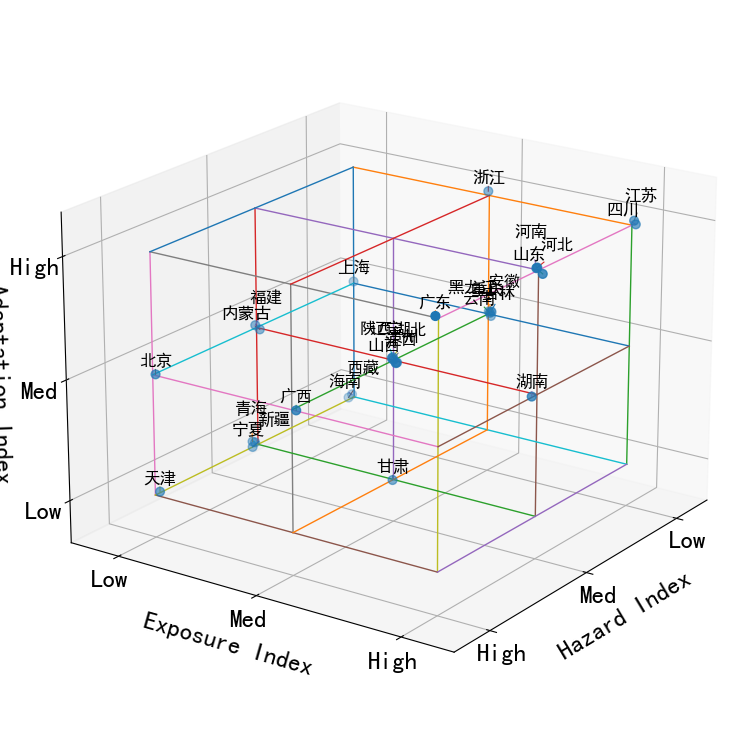

已保存立方体分布图（KMeans）： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\HEA_cube_by_province_means_kmeans.png


In [83]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib
from sklearn.cluster import KMeans
import json

# ===================== 0) 基本设置（按需修改） =====================
# 中文字体 & 负号正常显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']      # 或 ['Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False

excel_path = Path("hazard_exposure_adaptation_index_results-hazard1-AGE.xlsx")
sheet_name = 0                 # 或改为工作表名 "Sheet1"
PROVINCE_COL = "地区"          # 若你的列名是 "省份" / "Province"，请改这里
YEAR_COL     = "年份"          # 若没有年份列，设为 None
H_col = "Hazard Index"
E_col = "Exposure Index"
A_col = "Adaptation Index"

YEAR_MIN, YEAR_MAX = 2000, 2022  # 研究期（若无年份列将被忽略）

# 输出
out_csv = Path("province_mean_HEA_cube_kmeans.csv")
out_fig = Path("HEA_cube_by_province_means_kmeans.png")
out_centers_json = Path("kmeans_centers_HEA.json")

# KMeans 参数
N_CLUSTERS = 3
KMEANS_RANDOM_STATE = 0
KMEANS_N_INIT = 10

# ===================== 1) 读取与清洗 =====================
if not excel_path.exists():
    raise FileNotFoundError(f"未找到数据文件：{excel_path.resolve()}")

df = pd.read_excel(excel_path, sheet_name=sheet_name)
df.columns = [str(c).strip() for c in df.columns]

# 必要列检查
need_cols = [PROVINCE_COL, H_col, E_col, A_col]
if YEAR_COL and YEAR_COL in df.columns:
    need_cols.append(YEAR_COL)

missing = [c for c in [PROVINCE_COL, H_col, E_col, A_col] if c not in df.columns]
if missing:
    raise ValueError(f"缺少必要列：{missing}\n现有列：{list(df.columns)}")

df = df[need_cols].copy()

# 数值化 & 去缺失
for c in [H_col, E_col, A_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[H_col, E_col, A_col]).reset_index(drop=True)

# 年份限定（若存在年份列）
if YEAR_COL and YEAR_COL in df.columns:
    df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce")
    df = df[(df[YEAR_COL] >= YEAR_MIN) & (df[YEAR_COL] <= YEAR_MAX)]

# ===================== 2) 计算省份多年均值 =====================
df_mean = df.groupby(PROVINCE_COL)[[H_col, E_col, A_col]].mean().reset_index()
df_mean.rename(columns={H_col: "H_mean", E_col: "E_mean", A_col: "A_mean"}, inplace=True)

# ===================== 3) KMeans 聚类分档（替代百分位分档） =====================
def kmeans_binning(series: pd.Series, n_clusters=3, rs=0, n_init=10):
    """
    用 KMeans 将数值分成 n_clusters 类，返回：
    - labeled: 映射后的文字标签（Low/Med/High）
    - centers_sorted: 从小到大排序后的聚类中心（列表）
    - label_to_level: 原始label(0/1/2/...) -> 'Low'/'Med'/'High'/...
    - assigned_labels: 原始KMeans标签（与labeled等长）
    """
    km = KMeans(n_clusters=n_clusters, random_state=rs, n_init=n_init)
    arr = series.values.reshape(-1, 1)
    km.fit(arr)
    labels = km.labels_
    centers = km.cluster_centers_.flatten()

    # 小->大排序，并映射等级名称
    order = np.argsort(centers)
    std_levels = ["Low", "Med", "High"][:n_clusters]  # 若 n_clusters!=3，可自定义名称列表
    label_to_level = {order[i]: lvl for i, lvl in enumerate(std_levels)}
    labeled = pd.Series(labels).map(label_to_level).values
    centers_sorted = list(np.sort(centers))
    return labeled, centers_sorted, label_to_level, labels

# 各指标聚类分档
H_bin, H_centers_sorted, H_map, H_labels = kmeans_binning(
    df_mean["H_mean"], n_clusters=N_CLUSTERS, rs=KMEANS_RANDOM_STATE, n_init=KMEANS_N_INIT
)
E_bin, E_centers_sorted, E_map, E_labels = kmeans_binning(
    df_mean["E_mean"], n_clusters=N_CLUSTERS, rs=KMEANS_RANDOM_STATE, n_init=KMEANS_N_INIT
)
A_bin, A_centers_sorted, A_map, A_labels = kmeans_binning(
    df_mean["A_mean"], n_clusters=N_CLUSTERS, rs=KMEANS_RANDOM_STATE, n_init=KMEANS_N_INIT
)

df_mean["H_bin"] = H_bin
df_mean["E_bin"] = E_bin
df_mean["A_bin"] = A_bin
df_mean["H_label_raw"] = H_labels
df_mean["E_label_raw"] = E_labels
df_mean["A_label_raw"] = A_labels

# 将 Low/Med/High -> 0/1/2（用于立方体坐标）
level_to_num = {"Low": 0, "Med": 1, "High": 2}
df_mean["Hx"] = df_mean["H_bin"].map(level_to_num).astype(float)
df_mean["Ey"] = df_mean["E_bin"].map(level_to_num).astype(float)
df_mean["Az"] = df_mean["A_bin"].map(level_to_num).astype(float)

# 立方体格子编码与简写标签
df_mean["cube_cell"]  = "H" + df_mean["Hx"].astype(int).astype(str) + \
                        "-E" + df_mean["Ey"].astype(int).astype(str) + \
                        "-A" + df_mean["Az"].astype(int).astype(str)
df_mean["cube_label"] = df_mean["H_bin"].str[0] + df_mean["E_bin"].str[0] + df_mean["A_bin"].str[0]

# ===================== 3.5) 聚类中心（“标准”）并修复 JSON 序列化 =====================
def _cast_py(obj):
    """将 numpy 类型递归转换为原生 Python 类型，便于 JSON 序列化。"""
    if isinstance(obj, (np.generic,)):
        return obj.item()
    if isinstance(obj, dict):
        return {str(_cast_py(k)): _cast_py(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_cast_py(x) for x in obj]
    return obj

centers_dict = {
    "Hazard Index": {
        "centers_sorted": [float(x) for x in H_centers_sorted],
        "raw_label_to_level": {int(k): str(v) for k, v in H_map.items()}
    },
    "Exposure Index": {
        "centers_sorted": [float(x) for x in E_centers_sorted],
        "raw_label_to_level": {int(k): str(v) for k, v in E_map.items()}
    },
    "Adaptation Index": {
        "centers_sorted": [float(x) for x in A_centers_sorted],
        "raw_label_to_level": {int(k): str(v) for k, v in A_map.items()}
    }
}
centers_dict = _cast_py(centers_dict)

print("\n================= KMeans 聚类中心（从小到大） =================")
print(f"Hazard Index centers:     {centers_dict['Hazard Index']['centers_sorted']}")
print(f"Exposure Index centers:   {centers_dict['Exposure Index']['centers_sorted']}")
print(f"Adaptation Index centers: {centers_dict['Adaptation Index']['centers_sorted']}")
print("（说明：centers_sorted 表示各类的均值中心，从小到大排序；"
      "raw_label_to_level 给出原始簇号到 'Low/Med/High' 的映射）")

with open(out_centers_json, "w", encoding="utf-8") as f:
    json.dump(centers_dict, f, ensure_ascii=False, indent=2)
print(f"已保存聚类中心到：{out_centers_json.resolve()}")

# ===================== 4) 导出表格 =====================
df_mean.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("已导出省份多年均值与立方体分档（KMeans）：", out_csv.resolve())
print(df_mean.head())

# ===================== 5) 3×3×3 立方体散点图（每点=一个省份） =====================
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')

# 画立方体网格（0,1,2 三层）
ticks = [0, 1, 2]
for x in ticks:
    for y in ticks:
        ax.plot([x, x], [y, y], [0, 2], linewidth=1)
for x in ticks:
    for z in ticks:
        ax.plot([x, x], [0, 2], [z, z], linewidth=1)
for y in ticks:
    for z in ticks:
        ax.plot([0, 2], [y, y], [z, z], linewidth=1)

# 点位：在格子中心加少量随机抖动，避免多个省份重叠
np.random.seed(1)
X = df_mean["Hx"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06
Y = df_mean["Ey"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06
Z = df_mean["Az"].to_numpy() + (np.random.rand(len(df_mean)) - 0.5) * 0.06

ax.scatter(X, Y, Z, s=40)

# ---------------- 标签防重叠：按格子分组分散 + 轻微抬升，并加短领结线 ----------------
center_keys = list(zip(df_mean["Hx"].astype(int), df_mean["Ey"].astype(int), df_mean["Az"].astype(int)))
groups = {}
for idx, key in enumerate(center_keys):
    groups.setdefault(key, []).append(idx)

# 参数可按需要微调
r_base = 0.10     # 水平偏移半径（单位=格子坐标）
r_step = 0.02     # 多标签时逐步增大半径
z_step = 0.05     # 垂直方向错层步长
text_fs = 12     # 标签字号
line_len = 0.06   # 领结线长度

# 计算标签位置（与散点位置独立），再画领结线连回散点
for key, idx_list in groups.items():
    n = len(idx_list)
    if n == 1:
        # 只有一个标签：用原散点位置，稍微上抬一点
        i = idx_list[0]
        xi, yi, zi = X[i], Y[i], Z[i]
        xt, yt, zt = xi, yi, zi + z_step  # 轻微上抬
        # 领结线
        ax.plot([xi, xt], [yi, yt], [zi, zt - 0.01], linewidth=0.8)
        ax.text(xt, yt, zt, str(df_mean.loc[i, PROVINCE_COL]), fontsize=text_fs, ha='center', va='bottom')
    else:
        # 多个标签：均匀分布在圆上，并逐步增大半径、错层Z
        angles = np.linspace(0, 2*np.pi, n, endpoint=False)
        for rank, (i, ang) in enumerate(zip(idx_list, angles)):
            # 以整数格子中心为参照，构造标签位置（而不是直接用散点随机扰动）
            cx, cy, cz = key[0], key[1], key[2]
            r = r_base + r_step * (rank // 6)  # 标签多时逐圈扩散
            xt = cx + r * np.cos(ang)
            yt = cy + r * np.sin(ang)
            zt = cz + 0.10 + (rank % 3) * z_step  # 稍微抬高并错层

            # 领结线：从散点处拉一小段线到标签
            xi, yi, zi = X[i], Y[i], Z[i]
            vx, vy, vz = xt - xi, yt - yi, zt - zi
            norm = max(np.sqrt(vx*vx + vy*vy + vz*vz), 1e-6)
            px = xi + vx / norm * line_len
            py = yi + vy / norm * line_len
            pz = zi + vz / norm * line_len
            ax.plot([xi, px], [yi, py], [zi, pz], linewidth=0.8)

            ax.text(xt, yt, zt, str(df_mean.loc[i, PROVINCE_COL]), fontsize=text_fs, ha='center', va='bottom')

# 轴设置
ax.set_xlabel("Hazard Index")
ax.set_ylabel("Exposure Index")
ax.set_zlabel("Adaptation Index")
ax.set_xticks([0, 1, 2]); ax.set_yticks([0, 1, 2]); ax.set_zticks([0, 1, 2])
ax.set_xticklabels(["Low", "Med", "High"])
ax.set_yticklabels(["Low", "Med", "High"])
ax.set_zticklabels(["Low", "Med", "High"])
ax.set_xlim(-0.3, 2.3); ax.set_ylim(-0.3, 2.3); ax.set_zlim(-0.3, 2.3)
ax.view_init(elev=20, azim=35)

ax.set_xticklabels(["Low","Med","High"])
ax.set_yticklabels(["Low","Med","High"])
ax.set_zticklabels(["Low","Med","High"])

ax.xaxis.set_tick_params(pad=0.1)
ax.yaxis.set_tick_params(pad=0.01)
ax.zaxis.set_tick_params(pad=3)


ax.xaxis.labelpad = 6
ax.yaxis.labelpad = 6
ax.zaxis.labelpad = 6


# 边距（替代 tight_layout，以避免 3D 图装饰挤压告警）
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.savefig(out_fig, dpi=400, facecolor="none", transparent=True)
plt.show()
print("已保存立方体分布图（KMeans）：", out_fig.resolve())


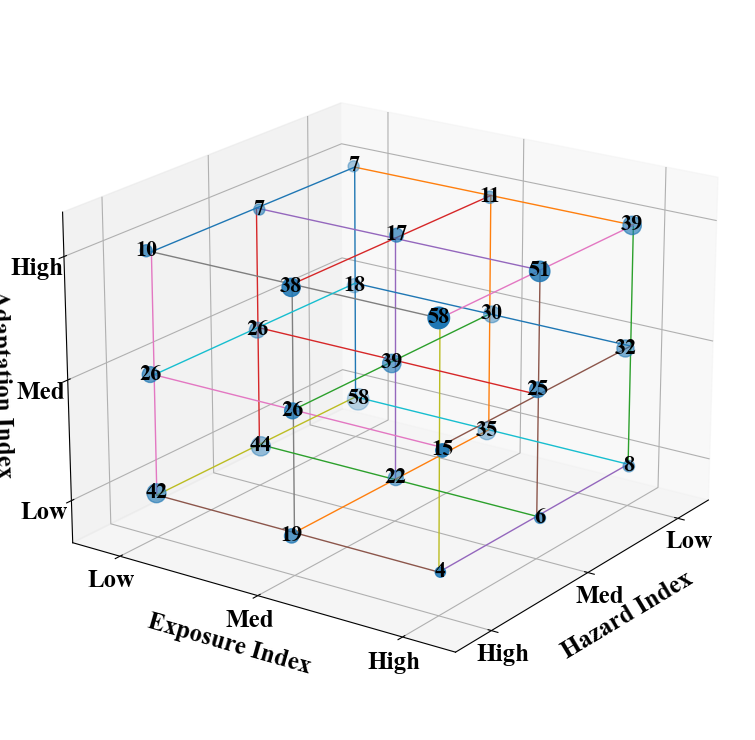

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

excel_path = Path("hazard_exposure_adaptation_index_results-hazard1-AGE.xlsx")
sheet_name = 0  # 或者写表名

# --------- 小工具：处理重名列只取第一个 ----------
def get_series_unique(df_in: pd.DataFrame, col_name: str) -> pd.Series:
    """当列名重复时，只取第一个同名列，确保返回 Series"""
    idx = [i for i, c in enumerate(df_in.columns) if c == col_name]
    if not idx:
        raise KeyError(f"列不存在：{col_name}")
    return df_in.iloc[:, idx[0]]

def tri_binning(series: pd.Series):
    q33, q67 = series.quantile([0.3333, 0.6667])
    bins = [-np.inf, q33, q67, np.inf]
    labels = ["Low", "Med", "High"]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# --------- 读取并清洗 ----------
dfe = pd.read_excel(excel_path, sheet_name=sheet_name)
dfe.columns = [str(c).strip() for c in dfe.columns]  # 去掉空格

# 固定列名
H_col = "Hazard Index"
E_col = "Exposure Index"
A_col = "Adaptation Index"

df_num = pd.DataFrame({
    "H": get_series_unique(dfe, H_col),
    "E": get_series_unique(dfe, E_col),
    "A": get_series_unique(dfe, A_col),
})

# 转数值
for c in ["H", "E", "A"]:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")
df_num = df_num.dropna().reset_index(drop=True)

# --------- 分档 ----------
df_num["H_bin"] = tri_binning(df_num["H"]).astype(str)
df_num["E_bin"] = tri_binning(df_num["E"]).astype(str)
df_num["A_bin"] = tri_binning(df_num["A"]).astype(str)

# --------- 3×3×3 计数与绘图 ----------
map3 = {"Low":0, "Med":1, "High":2}
df_num["Hx"] = df_num["H_bin"].map(map3)
df_num["Ey"] = df_num["E_bin"].map(map3)
df_num["Az"] = df_num["A_bin"].map(map3)

counts = df_num.groupby(["Hx","Ey","Az"]).size().reset_index(name="n")
if counts.empty:
    raise ValueError("分档为空，请检查 H/E/A 数据是否有效。")

fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制立方体网格
ticks = [0,1,2]
for x in ticks:
    for y in ticks:
        ax.plot([x,x],[y,y],[0,2], linewidth=1)
for x in ticks:
    for z in ticks:
        ax.plot([x,x],[0,2],[z,z], linewidth=1)
for y in ticks:
    for z in ticks:
        ax.plot([0,2],[y,y],[z,z], linewidth=1)

# 散点（点大小 ∝ 样本数）
np.random.seed(0)
X = counts["Hx"].values + (np.random.rand(len(counts))-0.5)*0.05
Y = counts["Ey"].values + (np.random.rand(len(counts))-0.5)*0.05
Z = counts["Az"].values + (np.random.rand(len(counts))-0.5)*0.05
S = 40 + (counts["n"].values / counts["n"].max()) * 200
ax.scatter(X, Y, Z, s=S)

# 标注样本数
for xi, yi, zi, ni in zip(X, Y, Z, counts["n"].values):
    ax.text(xi, yi, zi, str(int(ni)), fontsize=16, ha='center', va='center')

ax.set_xlabel("Hazard Index")
ax.set_ylabel("Exposure Index")
ax.set_zlabel("Adaptation Index")
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2]); ax.set_zticks([0,1,2])
ax.set_xticklabels(["Low","Med","High"])
ax.set_yticklabels(["Low","Med","High"])
ax.set_zticklabels(["Low","Med","High"])

ax.xaxis.set_tick_params(pad=0.1)
ax.yaxis.set_tick_params(pad=0.01)
ax.zaxis.set_tick_params(pad=3)


ax.xaxis.labelpad = 6
ax.yaxis.labelpad = 6
ax.zaxis.labelpad = 6

ax.set_xlim(-0.3, 2.3); ax.set_ylim(-0.3, 2.3); ax.set_zlim(-0.3, 2.3)
ax.view_init(elev=20, azim=35)
# ax.set_title("HEA 3×3×3 Cube (cells sized by count)")

# 边距（替代 tight_layout，以避免 3D 图装饰挤压告警）
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# plt.savefig(out_fig, dpi=400, bbox_inches='tight', facecolor="none", transparent=True)
# plt.show()
# print("已保存立方体分布图（KMeans）：", out_fig.resolve())

# plt.tight_layout()
# plt.savefig(r'E:\BaiduSyncdisk\热浪博士论文\论文图片\PD-05-04-风险指数分布-无健康指数-0910.png',
#             dpi=400, bbox_inches='tight', facecolor="none", transparent=True)

plt.savefig(r'E:\BaiduSyncdisk\热浪博士论文\论文图片\PD-05-04-风险指数分布-无健康指数-0911.png',
            dpi=400, facecolor="white", transparent=True)
plt.show()


In [6]:
# -*- coding: utf-8 -*-
"""
HEA 3×3×3 立方体分区 + KMeans 聚类（按指定列名）
- 指标列固定为：Hazard Index / Exposure Index / Adaptation Index
- H/E/A 各按 33%/67% 三分位切分为 Low/Med/High（3×3×3=27 个格子）
- 在“格子层面”聚类（默认 K=5），再映射回每条样本（省份-年份）
- 输出 CSV：hea_cube_clusters.csv
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans

# ===================== 1) 路径与基础参数 =====================
excel_path = Path("hazard_exposure_adaptation_index_results-hazard1-AGE.xlsx")  # ← 改成你的路径
sheet_name = 0    # 可改为具体工作表名/索引，例如 "Sheet1"
province_col = "地区"  # 若你的省份列是“地区/Province”等，请改这里
year_col = "年份"      # 如果没有年份列，可设为 None
K = 5
out_csv = Path("hea_cube_clusters.csv")

# 指标列固定名（与你的表一致）
H_col = "Hazard Index"
E_col = "Exposure Index"
A_col = "Adaptation Index"

# ===================== 2) 读数与检查 =====================
if not excel_path.exists():
    raise FileNotFoundError(f"未找到数据文件：{excel_path.resolve()}")

df_raw = pd.read_excel(excel_path, sheet_name=sheet_name)

need_cols = [province_col, H_col, E_col, A_col]
if year_col:
    need_cols.append(year_col)

missing = [c for c in need_cols if c not in df_raw.columns]
if missing:
    raise ValueError(f"缺少必要列：{missing}\n现有列：{list(df_raw.columns)}")

df = df_raw[need_cols].copy()

# 数值化 & 去缺失
for c in [H_col, E_col, A_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[H_col, E_col, A_col]).reset_index(drop=True)

# ===================== 3) 3×3×3 立方体分档 =====================
def tri_binning(series: pd.Series):
    q33, q67 = series.quantile([0.3333, 0.6667])
    bins = [-np.inf, q33, q67, np.inf]
    labels = ["Low", "Med", "High"]
    binned = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return binned.astype(str), {"q33": float(q33), "q67": float(q67)}

H_bin, H_thr = tri_binning(df[H_col])
E_bin, E_thr = tri_binning(df[E_col])
A_bin, A_thr = tri_binning(df[A_col])

df["H_bin"] = H_bin
df["E_bin"] = E_bin
df["A_bin"] = A_bin

map3 = {"Low": 0, "Med": 1, "High": 2}
df["H_bin_id"] = df["H_bin"].map(map3)
df["E_bin_id"] = df["E_bin"].map(map3)
df["A_bin_id"] = df["A_bin"].map(map3)

# 立方体格子编码与简写
df["cube_cell"]  = "H" + df["H_bin_id"].astype(str) + "-E" + df["E_bin_id"].astype(str) + "-A" + df["A_bin_id"].astype(str)
df["cube_label"] = df["H_bin"].str[0] + df["E_bin"].str[0] + df["A_bin"].str[0]

# ===================== 4) 在“格子层面”聚类 =====================
cell_stats = df.groupby("cube_cell").agg(
    H_mean=(H_col, "mean"),
    E_mean=(E_col, "mean"),
    A_mean=(A_col, "mean"),
    n=("cube_cell", "size")
).reset_index()

def minmax_norm(s: pd.Series) -> pd.Series:
    vmin, vmax = s.min(), s.max()
    if vmax == vmin:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - vmin) / (vmax - vmin)

for c in ["H_mean", "E_mean", "A_mean"]:
    cell_stats[c + "_n"] = minmax_norm(cell_stats[c])

kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)
cell_stats["cell_cluster"] = kmeans.fit_predict(cell_stats[["H_mean_n", "E_mean_n", "A_mean_n"]])

df = df.merge(cell_stats[["cube_cell", "cell_cluster"]], on="cube_cell", how="left")

# ===================== 5) 导出与摘要 =====================
front_cols = [province_col] + ([year_col] if year_col else []) + [
    H_col, E_col, A_col, "H_bin", "E_bin", "A_bin", "cube_cell", "cube_label", "cell_cluster"
]
df_out = df[front_cols].copy()
df_out.to_csv(out_csv, index=False, encoding="utf-8-sig")

summary = {
    "输出文件": str(out_csv.resolve()),
    "样本条数": len(df_out),
    "省份数": df_out[province_col].nunique(),
    "年份数": (df_out[year_col].nunique() if year_col and year_col in df_out.columns else "无年份列/未统计"),
    "三分位阈值": {"Hazard Index": H_thr, "Exposure Index": E_thr, "Adaptation Index": A_thr},
    "出现过的立方体格子数": int(cell_stats.shape[0]),
    "KMeans_K": K,
    "各聚类样本数": df_out["cell_cluster"].value_counts().to_dict()
}
summary


D:\Users\HP\miniconda3\envs\ee\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


{'输出文件': 'E:\\BaiduSyncdisk\\热浪博士论文\\计算表格\\Chapter5\\hea_cube_clusters.csv',
 '样本条数': 713,
 '省份数': 31,
 '年份数': 23,
 '三分位阈值': {'Hazard Index': {'q33': 0.35322326254640185,
   'q67': 0.4784736728789493},
  'Exposure Index': {'q33': 0.23367685659619167, 'q67': 0.43245600808570533},
  'Adaptation Index': {'q33': 0.15334892448552154, 'q67': 0.2965035953262278}},
 '出现过的立方体格子数': 27,
 'KMeans_K': 5,
 '各聚类样本数': {1: 188, 4: 148, 3: 137, 2: 123, 0: 117}}

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# ===== 1. 读取数据 =====
excel_path = Path("hazard_exposure_adaptation_index_results-hazard1-AGE.xlsx")
sheet_name = 0
province_col = "地区"     # 或 "地区"/"Province"
H_col = "Hazard Index"
E_col = "Exposure Index"
A_col = "Adaptation Index"

df = pd.read_excel(excel_path, sheet_name=sheet_name)

# ===== 2. 按省份计算均值 =====
df_mean = df.groupby(province_col)[[H_col, E_col, A_col]].mean().reset_index()

# ===== 3. 归一化 =====
scaler = MinMaxScaler()
X = scaler.fit_transform(df_mean[[H_col, E_col, A_col]])

# ===== 4. 聚类 =====
K = 5   # 聚类数，可调
kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)
df_mean["cluster"] = kmeans.fit_predict(X)

# ===== 5. 输出结果 =====
out_csv = Path("province_mean_index_clusters.csv")
df_mean.to_csv(out_csv, index=False, encoding="utf-8-sig")

print("输出文件：", out_csv.resolve())
print(df_mean.head())


D:\Users\HP\miniconda3\envs\ee\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


输出文件： E:\BaiduSyncdisk\热浪博士论文\计算表格\Chapter5\province_mean_index_clusters.csv
    地区  Hazard Index  Exposure Index  Adaptation Index  cluster
0   上海      0.297080        0.176498          0.263943        4
1   云南      0.336523        0.436850          0.224909        2
2  内蒙古      0.452430        0.211095          0.183854        0
3   北京      0.480636        0.099909          0.305862        0
4   吉林      0.389131        0.254259          0.183897        2
